#### PyTorch CNN MNIST

In [1]:

import torch
import numpy as np

import idx2numpy
import matplotlib.cm as cm
import matplotlib.pyplot as plt

PATH = 'C:/Projects/keras_talk/keras/intern/0709/MNIST/'
EPOCHS = 10
BATCH_SIZE = 100


#### data

In [2]:
x_test_path = 't10k-images.idx3-ubyte'
y_test_path = 't10k-labels.idx1-ubyte'
x_train_path = 'train-images.idx3-ubyte'
y_train_path = 'train-labels.idx1-ubyte'


x_test = idx2numpy.convert_from_file(PATH+x_test_path)
y_test = idx2numpy.convert_from_file(PATH+y_test_path)
x_train = idx2numpy.convert_from_file(PATH+x_train_path)
y_train = idx2numpy.convert_from_file(PATH+y_train_path)


x_test  = x_test.reshape ( len(x_test),  1, 28, 28).astype('float32') / 255.
x_train = x_train.reshape( len(x_train), 1, 28, 28).astype('float32') / 255.        
#y_test  = one_hot_encoding(y_test,10)
#y_train = one_hot_encoding(y_train,10)


#### Data_loader 구성

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


x_test  = torch.from_numpy(x_test ).float().to('cpu')
x_train = torch.from_numpy(x_train).float().to('cpu')
y_test  = torch.from_numpy(y_test ).long().to('cpu')
y_train = torch.from_numpy(y_train).long().to('cpu')


dataset      = TensorDataset(x_train, y_train)
dataset_test = TensorDataset(x_test, y_test)

dataloader      = DataLoader( dataset, batch_size = BATCH_SIZE
                        ,shuffle= True, drop_last = True ) 
dataloader_test = DataLoader( dataset_test, batch_size = BATCH_SIZE
                        ,shuffle= True, drop_last = True )

..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


#### pytorch model 구성

In [4]:
import torch.nn
import torch.nn.functional
import torch.optim

class CNN( torch.nn.Module ):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1  = torch.nn.Conv2d( in_channels =  1, out_channels = 16, kernel_size = 3 )
        self.Crelu1 = torch.nn.ReLU()
        self.conv2  = torch.nn.Conv2d( in_channels = 16, out_channels = 32, kernel_size = 3 )
        self.Crelu2 = torch.nn.ReLU()
        self.maxpl  = torch.nn.MaxPool2d( kernel_size=2 )
        #flatten()
        self.dropout= torch.nn.Dropout()
        self.lay1   = torch.nn.Linear( 12*12*32, 32 )
        self.Lrelu1 = torch.nn.ReLU()
        self.lay2   = torch.nn.Linear( 32, 10 )
        
        
    def forward(self, x):
        output = self.conv1(x)
        output = self.Crelu1(output)
        output = self.conv2(output)
        output = self.Crelu2(output)
        output = self.maxpl(output)
        output = output.view(-1,12*12*32)
        output = self.dropout(output)
        output = self.lay1(output)
        output = self.Lrelu1(output)
        output = self.lay2(output)
        output = torch.nn.functional.softmax(output, dim=1)
        
        return output
        



#### https://tensorflow.blog/2017/01/26/pytorch-mnist-example/
#####  MnistModel은 위 블로그 게시물 참고하여 구성하였습니다.

In [5]:
class MnistModel(torch.nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv1  = torch.nn.Conv2d( 1, 32, 5, padding=2)
        self.conv2  = torch.nn.Conv2d(32, 64, 5, padding=2)
        #Flatten
        self.layer1 = torch.nn.Linear(64*7*7, 1024)
        self.layer2 = torch.nn.Linear(1024, 10)
    
    def forward(self, x):
        output = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv1(x)), 2)
        output = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv2(output)), 2)
        output = output.view(-1, 64*7*7)
        output = torch.nn.functional.relu(self.layer1(output))
        output=  torch.nn.functional.dropout(output, training=self.training)
        output = torch.nn.functional.log_softmax(self.layer2(output), dim=1) 
        
        return output     
        

#### model 학습

In [6]:
from torch.autograd import Variable
torch.manual_seed(1)

#model = CNN()
model = MnistModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_loss = []
train_acc  = []


model.train()
for epoch in range(EPOCHS):
        
    print('epoch'+str(epoch+1))
    for i,(data, label) in enumerate(dataloader):
        #data, label = Variable(data), Variable(label)
        optimizer.zero_grad()
        output = model(data)
        #loss = criterion(output, label)
        loss = torch.nn.functional.nll_loss(output, label)
        loss.backward()
        train_loss.append(loss.item())
        
        optimizer.step()
        total = label.size(0)
        preds = output.data.max(1)[1]
        correct = (preds==label).sum().item()
        accuracy = correct/BATCH_SIZE*100
        train_acc.append( accuracy )
        
        if i % BATCH_SIZE == 0:
            print('\tLoss:{:.3f}\tAcc:{:.3f}'.format(loss.item(),accuracy))
        
    
    
    

epoch1
	Loss:2.293	Acc:8.000
	Loss:0.678	Acc:77.000
	Loss:0.446	Acc:84.000
	Loss:0.215	Acc:94.000
	Loss:0.272	Acc:94.000
	Loss:0.208	Acc:94.000
epoch2
	Loss:0.133	Acc:98.000
	Loss:0.078	Acc:98.000
	Loss:0.161	Acc:97.000
	Loss:0.100	Acc:97.000
	Loss:0.158	Acc:96.000
	Loss:0.077	Acc:99.000
epoch3
	Loss:0.118	Acc:97.000
	Loss:0.034	Acc:99.000
	Loss:0.024	Acc:100.000
	Loss:0.034	Acc:100.000
	Loss:0.037	Acc:99.000
	Loss:0.032	Acc:99.000
epoch4
	Loss:0.082	Acc:96.000
	Loss:0.047	Acc:97.000
	Loss:0.091	Acc:96.000
	Loss:0.039	Acc:98.000
	Loss:0.081	Acc:97.000
	Loss:0.033	Acc:98.000
epoch5
	Loss:0.056	Acc:98.000
	Loss:0.033	Acc:98.000
	Loss:0.068	Acc:97.000
	Loss:0.109	Acc:97.000
	Loss:0.071	Acc:97.000
	Loss:0.064	Acc:97.000
epoch6
	Loss:0.068	Acc:98.000
	Loss:0.049	Acc:99.000
	Loss:0.025	Acc:99.000
	Loss:0.066	Acc:99.000
	Loss:0.039	Acc:98.000
	Loss:0.026	Acc:99.000
epoch7
	Loss:0.040	Acc:99.000
	Loss:0.022	Acc:99.000
	Loss:0.024	Acc:99.000
	Loss:0.038	Acc:99.000
	Loss:0.046	Acc:97.000
	Loss:0

#### 학습 결과

Test Accuracy:  99.06


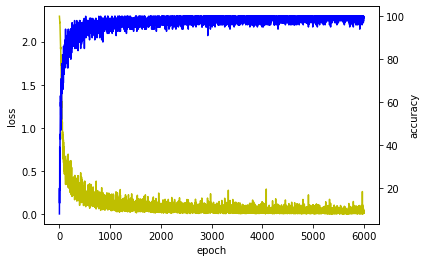

In [10]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for data, label in dataloader_test:
        output = model(data)
        preds  = torch.max(output.data, 1)[1]
        total   += len(label)
        correct += (preds==label).sum().item()
    print('Test Accuracy: ', 100.*correct/total)
    

%matplotlib inline
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(np.asarray(train_loss), 'y')
acc_ax.plot( np.asarray(train_acc),  'b')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

plt.show()
